# Deep Learning Project
- KP
- CCS
- JND


\\

\\
**Trajectory Prediction** 


is the problem of predicting the short-term (1-3 seconds) and long-term (3-5 seconds) spatial coordinates of various road-agents such as cars, buses, pedestrians, rickshaws, and animals, etc. These road-agents have different dynamic behaviors that may correspond to aggressive or conservative driving styles.



## 1. Requirements

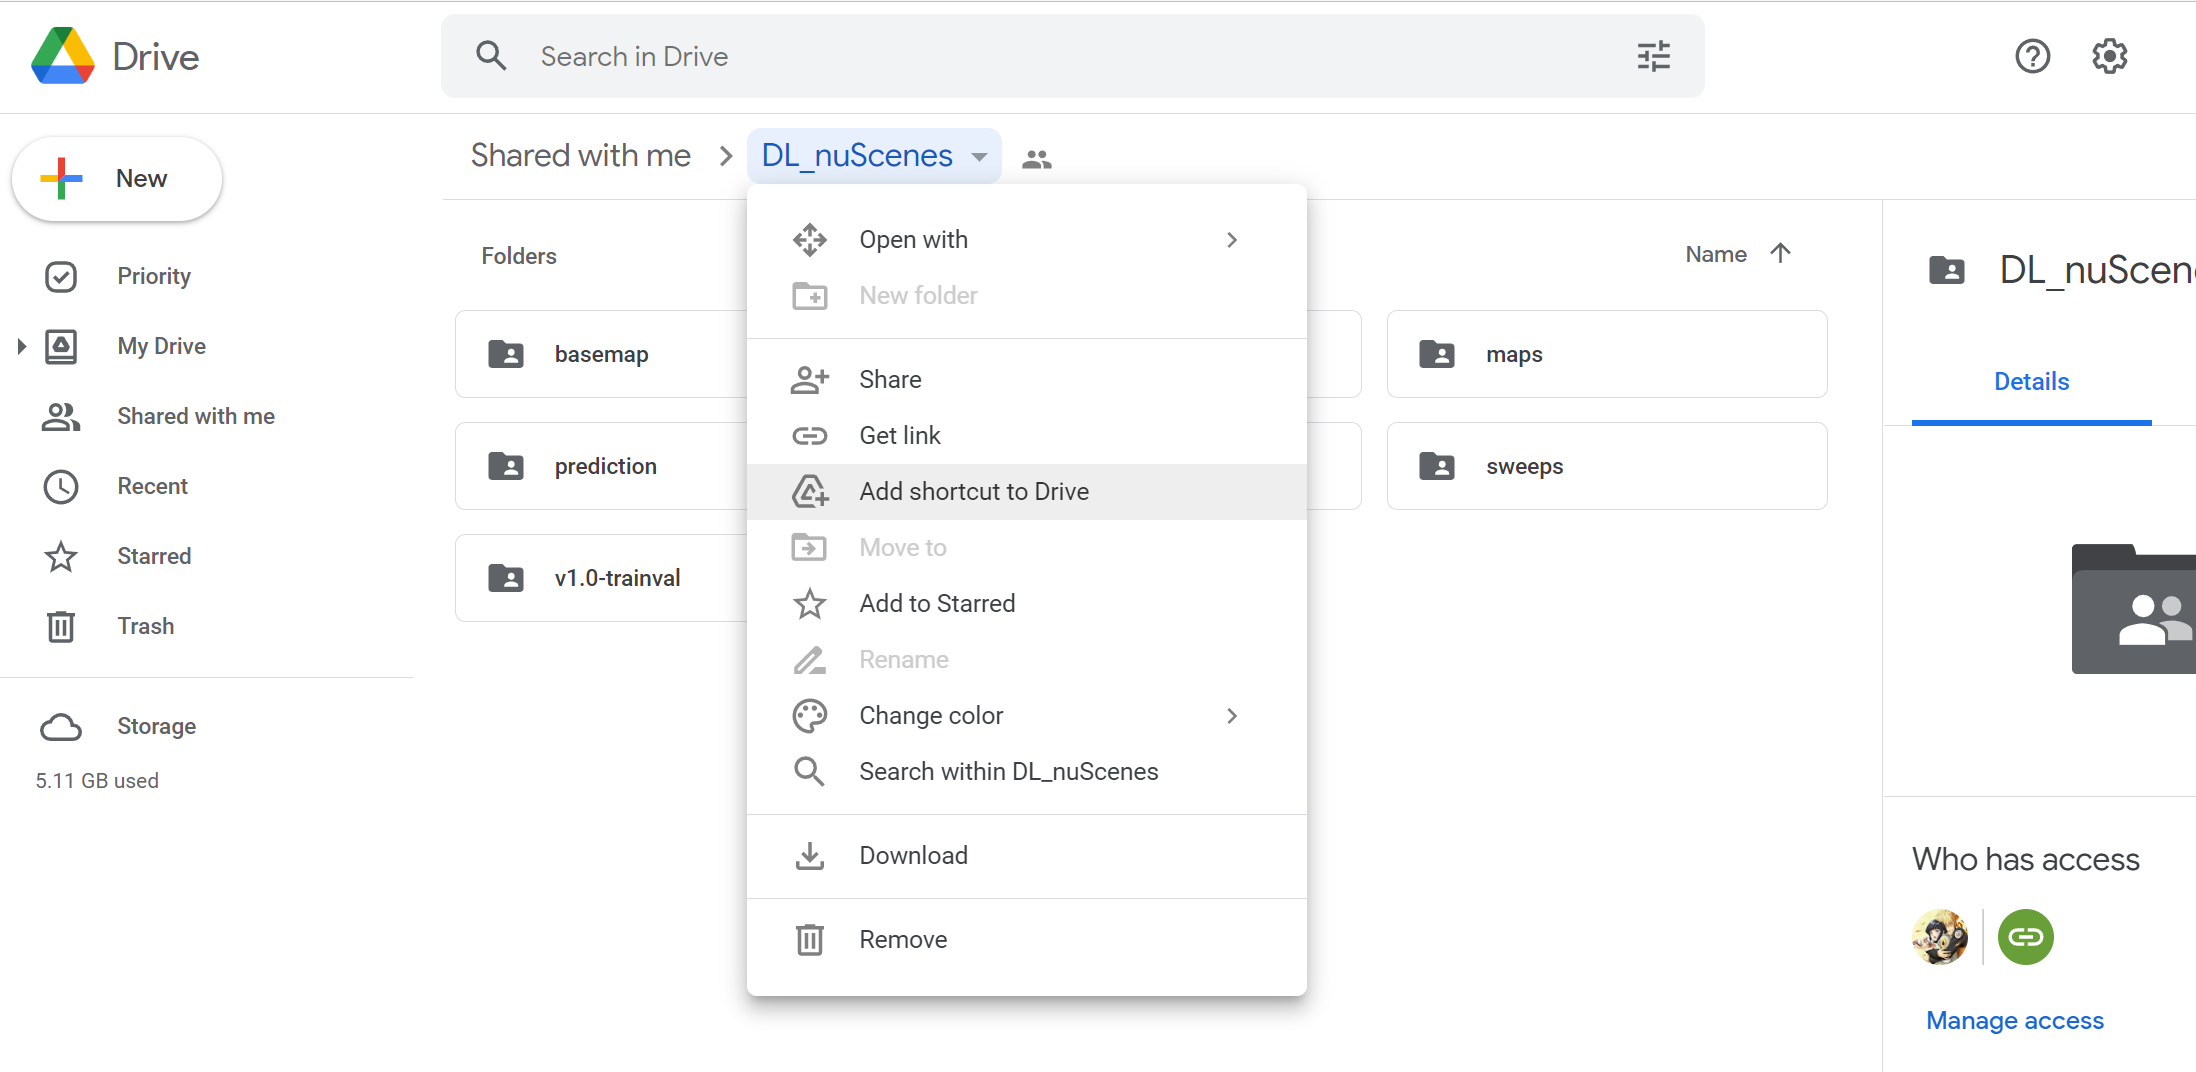

The dataset folder link is https://drive.google.com/drive/folders/118Z18sWEg4CqHAhFcYmDqXvDj2qk4YtI?usp=sharing , check "Add shortcut to Drive" and then you can import it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# nuscenes-devkit tools 
!pip install nuscenes-devkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 312 kB 4.2 MB/s 
     |████████████████████████████████| 87 kB 7.0 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=e34aeec1b75f01861d76f4e18dd809cc92bfe312e5d5610e4f92406f8e5eb345
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
# math
import numpy as np
import math

# torch
import torch
import torch.nn as nn
from torch.autograd import Variable

# generic
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import gc

# nuscenes
import nuscenes
from nuscenes.eval.prediction import metrics
from nuscenes.prediction import PredictHelper

# plot
import matplotlib.pyplot as plt

## 2. Using GPU

In [ ]:
# Using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
white_list = ['white_list', 'trajectory']
flag = True

for key in globals().copy().keys():
  if not key.startswith("__"):
    if flag:
      white_list.append(key)
    if key == 'device':
      flag = False

## 3. Import Data

**Dataset.** 


nuScenes - Available at. https://www.nuscenes.org/nuscenes. The nuScenes dataset is a large-scale autonomous driving dataset. The dataset has 3D bounding boxes for 1000 scenes collected in Boston and Singapore. Each scene is 20 seconds long and annotated at 2Hz. This results in a total of 28130 samples for training, 6019 samples for validation and 6008 samples for testing. The dataset has the full autonomous vehicle data suite: 32- beam LiDAR, 6 cameras and radars with complete 360° coverage. The 3D object detection challenge evaluates the performance on 10 classes: cars, trucks, buses, trailers, construction vehicles, pedestrians, motorcycles, bicycles, traffic cones and barriers.

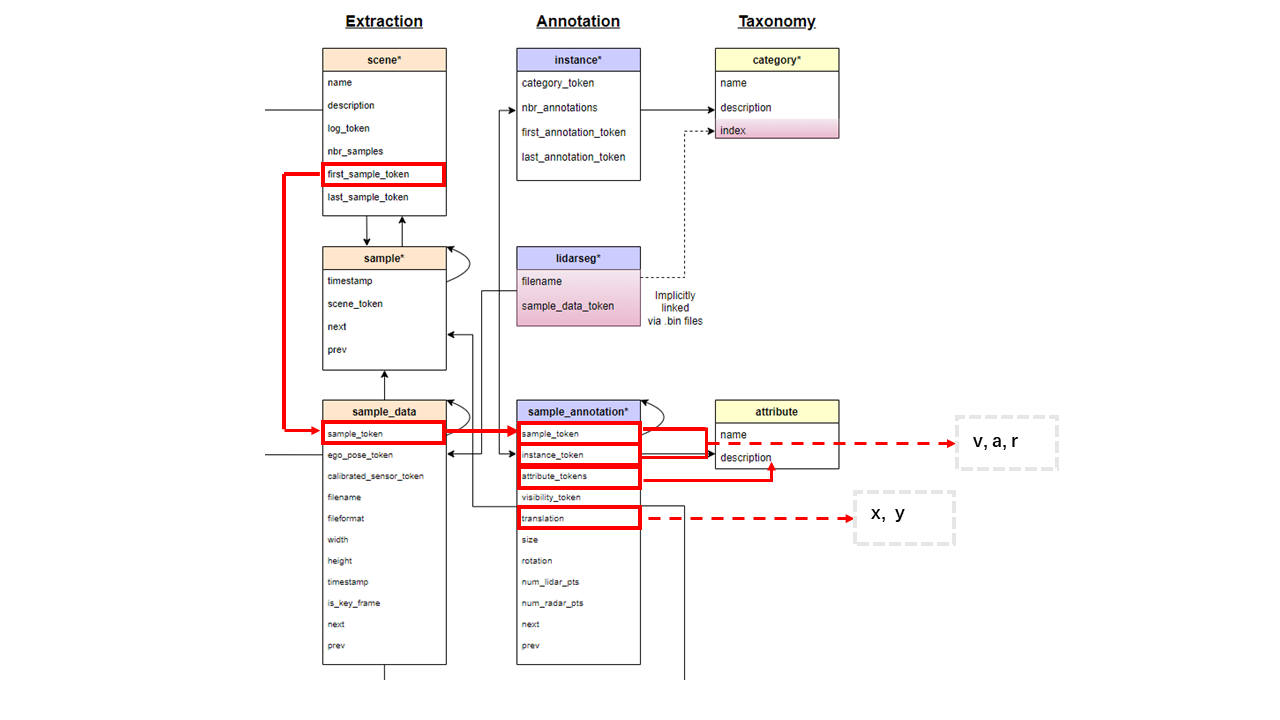

Download data:

- [Map expansion](https://www.nuscenes.org/nuscenes#)
- [Trainval](https://www.nuscenes.org/nuscenes#)

In [ ]:
nus = nuscenes.nuscenes.NuScenes('v1.0-trainval', dataroot='/content/drive/MyDrive/DL_nuScenes')
helper = PredictHelper(nus)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 92.825 seconds.
Reverse indexing ...
Done reverse indexing in 12.1 seconds.


### 3.1 Get Trajectory Points Data

In [ ]:
def next_sample(next_sample_token, frame_id, trajectory_data):
    sample = nus.get("sample", next_sample_token)

    for ann_token in sample['anns']:
        save_ann(frame_id, ann_token, trajectory_data)

    if sample['next'] == '':
        return
    else:
        next_sample(sample['next'], frame_id + 1, trajectory_data)


def save_ann(frame_id, ann_token, trajectory_data):
    ann = nus.get("sample_annotation", ann_token)
    if len(ann['attribute_tokens']) > 0:
        att = nus.get('attribute', ann['attribute_tokens'][0])

        data = []
        data.append(frame_id)
        data.append(ann['instance_token'])
        data.append(ann['translation'][0])
        data.append(ann['translation'][1])
        data.append(ann['translation'][2])
        data.append(helper.get_velocity_for_agent(
            ann['instance_token'], ann['sample_token']))
        data.append(helper.get_acceleration_for_agent(
            ann['instance_token'], ann['sample_token']))
        data.append(helper.get_heading_change_rate_for_agent(
            ann['instance_token'], ann['sample_token']))

        if ann['category_name'][0] == 'v' and att['name'] == 'vehicle.parked':
            data.append(0)
        else:
            data.append(1)

        trajectory_data.append(data)


def get_points_data(nus):
    trajectory_data = []
    print("Processing points data: ")
    for scene in tqdm(range(len(nus.scene))):  # Scene
        first_sample_token = nus.scene[scene]["first_sample_token"]  # sample
        frame_id = 0
        next_sample(first_sample_token, frame_id, trajectory_data)
    return trajectory_data

In [ ]:
trajectory_data = get_points_data(nus)

Processing points data: 


  0%|          | 0/850 [00:00<?, ?it/s]

### 3.2 Get Unique Instance IDs

The order of trajectory points is chaotic, so we extract the unique instance id for reorganizing the order of trajectory points of each instance

In [ ]:
def get_unique_instance_id(trajectory_data):
    instance_ids = []

    for i in tqdm(range(len(trajectory_data))):
        instance_ids.append(trajectory_data[i][1])

    uni_instance_ids = np.unique(np.array(instance_ids))

    return uni_instance_ids

In [ ]:
uni_instance_ids = get_unique_instance_id(trajectory_data)

  0%|          | 0/877993 [00:00<?, ?it/s]

### 3.3 Get Trajectories

- Using unique instance ids to reorganize the order of trajectory points of each instance.



- Because our model needs **8 points for training** and **12 points for predicting**, only the trajectories longer than 20 points are accepted.

In [ ]:
def get_trajectories(trajectory_data, uni_instance_ids):
    trajectory = []
    trajectories = {item: [] for item in uni_instance_ids}

    print("Processing trajectories data: ")

    for item in tqdm(trajectory_data):
        if item[1] in uni_instance_ids:
            trajectories[item[1]].append(item)

    trajectories_list = list(trajectories.values())

    real_trajectories = []

    for tra in trajectories_list:
        if len(tra) > 21:
            real_trajectories.append(tra)
    print("Done! The length of trajectories is ", len(real_trajectories))
    return np.array(real_trajectories)

In [ ]:
trajectory = get_trajectories(trajectory_data, uni_instance_ids)

Processing trajectories data: 


  0%|          | 0/877993 [00:00<?, ?it/s]

Done! The length of trajectories is  17503


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
for key in globals().copy().keys():
  if not key.startswith("__"):
    if not key in white_list:
      globals().pop(key)
gc.collect()

104

In [ ]:
gc.collect()

13848663

### 3.4 Spliting Datasets


- Spliting the dataset:
  - 60% as training data
  - 20% as validation data
  - 20% as test data

In [ ]:
train_data = trajectory[0:int(len(trajectory) * 0.6)]
val_data = trajectory[int(len(trajectory) * 0.6): int(len(trajectory) * 0.8)]
test_data = trajectory[int(len(trajectory) * 0.8):]

## 4. Utils
- Our tools



In [ ]:
def sliding_window(data, SEQ_LENGTH):
    """using sliding window divide the single trajectory into several train samples
    """
    origin_xs = []
    expected_xs = []
    for i in range(len(data) - SEQ_LENGTH - 11):
        origin_x = data[i: (i + SEQ_LENGTH)]
        expected_x = data[(i + SEQ_LENGTH): (i + SEQ_LENGTH + 12)]
        origin_xs.append(origin_x)
        expected_xs.append(expected_x)
    return np.array(origin_xs), np.array(expected_xs)


def reshape_data_1(x):
    """convert the data to tensor and reshape
    """
    X = torch.tensor(np.array(x), dtype=torch.float32)
    X = torch.reshape(X, (X.shape[0], 1))
    return X


def reshape_data_2(x):
    """convert the data to tensor and reshape
    """
    X = torch.tensor(np.array(x), dtype=torch.float32)
    X = torch.reshape(X, (X.shape[0], X.shape[1], 1))
    return X


def costruct_train_dataset(trajectory, SEQ_LENGTH):
    """contruct the train dataset
    """
    tra = []
    for t in trajectory:
        tra.append(t[2:7])

    # scaling data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    xyvar = scaler.fit_transform(tra)

    # get x, y, speed, accleration, heading rate
    x, y, v, a, r = xyvar[:, 0], xyvar[:,
                                       1], xyvar[:, 2], xyvar[:, 3], xyvar[:, 4]

    # using sliding_window to get the train data
    x, exp_x = sliding_window(x, SEQ_LENGTH)
    y, exp_y = sliding_window(y, SEQ_LENGTH)
    v, exp_v = sliding_window(v, SEQ_LENGTH)
    a, exp_a = sliding_window(a, SEQ_LENGTH)
    r, exp_r = sliding_window(r, SEQ_LENGTH)

    # reshape x, y, ground x and y
    dataX = reshape_data_2(x)
    dataY = reshape_data_2(y)
    exp_x = reshape_data_2(exp_x)
    exp_y = reshape_data_2(exp_y)

    # reshape speed, accleration, heading rate
    dataV = reshape_data_2(v)
    dataA = reshape_data_2(a)
    dataR = reshape_data_2(r)
    exp_v = reshape_data_2(exp_v)
    exp_a = reshape_data_2(exp_a)
    exp_r = reshape_data_2(exp_r)

    return dataX, dataY, exp_x, exp_y, dataV, exp_v, dataA, exp_a, dataR, exp_r


def clean_nan(tra):
    """ Remove nan point
    """
    tra_new = []
    for t in tra:
        if math.isnan(t[4]) or math.isnan(t[5]) or math.isnan(t[6]):
            continue
        else:
            tra_new.append(t)
    return tra_new


def traj2modes(trajs):
    """Convert data type to numpy.array
    """
    return np.array([trajs])

## 5. Model



We have tried many different architecture of models include baselines and our modified architecture , then compared their performance respectively.  And our final modified model has the best performance.


- First we tested a model that used basic LSTM model, which use incremental prediction, in the iteration, we predict the next point (x, y) of the trajectory in turn, and then use (x, y) as the training trajectory point to add to the sequence.


- As we know, this basic method have a big flaw when we have predict a long frames squence, because it's have a accumulated error. So we want to get the whole predicted position sequence at once as output throughout Linear layer.

### 5.1 LSTM + LinearX, LinearY
- [Code Link](https://colab.research.google.com/drive/1GFNBxcYfbNqtltdHGVLmRfCC-Q5a5ivK?usp=sharing)
- This is a plain basline which has accumlated error with 
iteration prediction. The following models are all modified 
architectures except this.

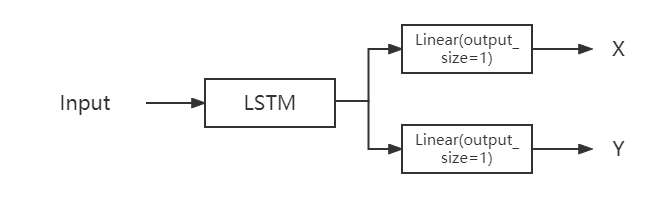



### 5.2 LSTM + Linear + LinearX, LinearY
- Add one more Linearr Layer to change the output to whole prediction.
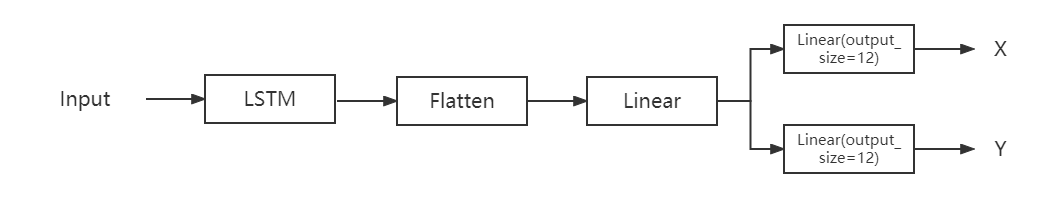

### 5.3 LSTM + LinearXY
- Remove the last two Linear output layers to increase 
the effect of LSTM on loss.
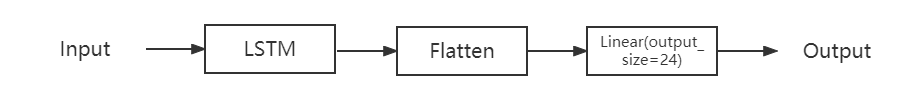

### 5.4 Conv1D + Linear + LinearX, LinearY
- [Code Link](https://colab.research.google.com/drive/1WEYCfWhV2OyPEEdP4YKwZU3AhyvExuEL#scrollTo=7IuPfoPGZfVD)
- Add a CNN layer instead of LSTM to extract the feature of sequence. 
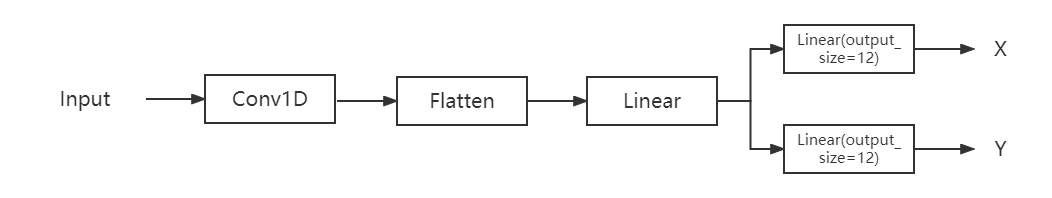

### 5.5 Conv1D + LinearXY
- Same as 5.3, increase the effect of CNN on loss.
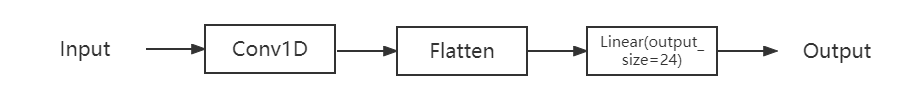

### 5.6 Conv1D + LSTM + Linear + LinearX, LinearY
- [Code Link](https://colab.research.google.com/drive/1C6lxeM4XG24USte5rYujX41FEUvchGuM#scrollTo=7IuPfoPGZfVD)
- Keep the LSTM to extract the time sequence information.
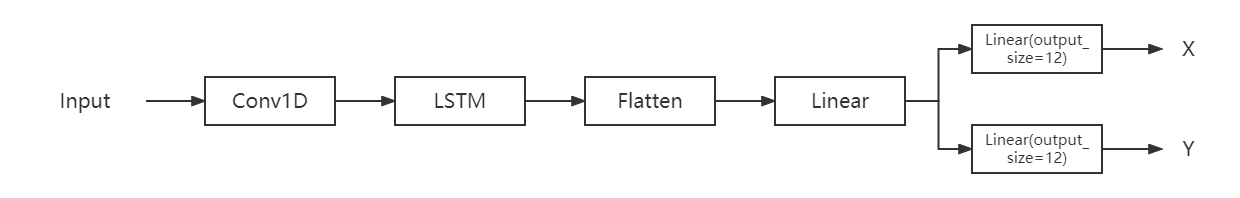

### 5.7 Our final model: Conv1D + LSTM + LinearXY
- Same as 5.3, 5.5, and then get our final model.
- The architecture of model as follow.
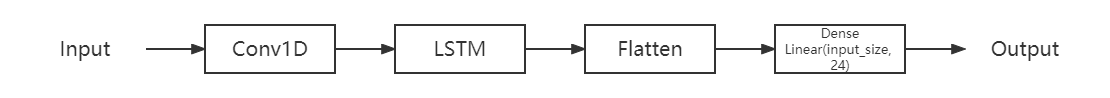

In [ ]:
class Model(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        '''
        data: [batch, sequence, data]
        '''
        super(Model, self).__init__()
        # model size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        # layers
        self.cnn = nn.Conv1d(5, 32, 3)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        # dense
        self.fc0 = nn.Linear(32 * 6, 24)
        

    def forward(self, data):
        ''' 
        data: [b, 8, 5]
        '''
        # #[1, b, 64]
        h_0 = Variable(torch.zeros(self.num_layers,
                       data.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers,
                       data.size(0), self.hidden_size)).to(device)

        # Conv1d
        # [b, 8, 5] -> [b, 5, 8]
        data = torch.permute(data, (0, 2, 1))
        # [b, 5, 8] -> [b, 32, 6]
        data = self.cnn(data)

        # [b, 32, 6] -> [b, 6, 32]
        data = torch.permute(data, (0, 2, 1))
        # LSTM
        # [b, 6, 32] -> [b, 6, 32]
        out, (_, _) = self.lstm(data, (h_0, c_0))

        # Dense
        # flatten [b, 6, 32] -> [b, 6*32]
        out = torch.flatten(out, start_dim=1)
        # [b, 6*32] -> [b, 24]
        out = self.fc0(out)

        # output
        # [b, 24] -> [b, 12]
        out_x = out[:, :12]
        # [b, 24] -> [b, 12]
        out_y = out[:, 12:]
        # [b, 12] -> [b, 12, 1]
        out_x = torch.reshape(out_x, (out_x.shape[0], out_x.shape[1], 1))
        # [b, 12] -> [b, 12, 1]
        out_y = torch.reshape(out_y, (out_y.shape[0], out_y.shape[1], 1))

        return out_x, out_y

## 6.Training

### 6.1 Train Function
- In order to crop the data into the same shape and expand the 
training set data，we divide the single trajectory into several samples
using silding window. 

- We chose the five features contain target x, y, speed, 
acceleration and heading rate as input feed to the model, 
and get the predicted (x, y) as output to Propagate loss.


In [ ]:
def train_func(trajectory, model, SEQ_LENGTH, epoch, optimizer, loss_func):
    model.train()
    Interval = 200
    train_loss = 0
    train_loss_in_batches = []
    interval_loss = 0
    i = 0

    for tra in trajectory:
        # clean nan
        tra = clean_nan(tra)

        # remove short trajectories
        if len(tra) < 20 or tra[0][-1] == 0:
            continue

        # zero grad
        optimizer.zero_grad()

        # get trajectories
        x, y, ex, ey, v, ev, a, ea, r, er = costruct_train_dataset(
            tra, SEQ_LENGTH)

        # cat train data
        cat_data = torch.cat([x, y, v, a, r], dim=2)
        cat_data = cat_data.to(device)

        # lstm model
        predicted_output_x, predicted_output_y = model(cat_data)

        # loss
        ex, ey = ex.to(device), ey.to(device)
        loss_x = loss_func(predicted_output_x, ex)
        loss_y = loss_func(predicted_output_y, ey)
        loss = loss_x + loss_y
        train_loss += loss
        interval_loss += loss

        # loss backward
        loss.backward()

        # optimizer
        optimizer.step()

        # train samples count
        i += 1

        # print loss
        if i % Interval == 0 and i > 0:
            print(
                f"| Epoch {epoch:3d} | {i:5d}/5400   batches | loss: {interval_loss / Interval:8.3f}")
            # whole losses
            train_loss_in_batches.append((interval_loss / Interval).cpu().data)
            interval_loss = 0

    return train_loss / len(trajectory), train_loss_in_batches


def val_func(trajectory, lstm, SEQ_LENGTH, epoch, loss_func):
    lstm.eval()
    cum_loss = 0
    length = len(trajectory)
    loss_in_batches = []

    with torch.no_grad():
        for tra in trajectory:
            # clean nan
            tra = clean_nan(tra)

            # remove short trajectories
            if len(tra) < 20 or tra[0][-1] == 0:
                length -= 1
                continue
            # get trajectories
            x, y, ex, ey, v, ev, a, ea, r, er = costruct_train_dataset(
                tra, SEQ_LENGTH)

            # cat val data
            cat_data = torch.cat([x, y, v, a, r], dim=2)
            cat_data = cat_data.to(device)

            # model
            predicted_output_x, predicted_output_y = lstm(cat_data)

            # loss
            ex, ey = ex.to(device), ey.to(device)
            loss_x = loss_func(predicted_output_x, ex)
            loss_y = loss_func(predicted_output_y, ey)
            cum_loss += (loss_x + loss_y)
            # print loss
    print(
        f'| Validation Epoch {epoch:3d} | Avg-Val Loss: {cum_loss / (length)}')

    return cum_loss / length

### 6.2 Model Instantiation
- The input shape is 5 which is (x, y, v, a, r)
- And data trained on GPU

In [ ]:
cnn_lstm = Model(32, 32, 1)
cnn_lstm = cnn_lstm.to(device)
LEARNING_RATE = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

### 6.3 Train Model
- Trianing preocess with epoch = 6

In [ ]:
PREDICTED_LENGTH = 12
SEQ_LENGTH = 8
EPOCH = 6

t_loss_in_batches = []
t_loss = []
v_loss = []

for epoch in range(EPOCH):
    train_loss, train_loss_in_batches = train_func(
        train_data, cnn_lstm, SEQ_LENGTH, epoch, optimizer, loss_func)
    val_loss = val_func(val_data, cnn_lstm, SEQ_LENGTH, epoch, loss_func)
    t_loss.append(train_loss.item())
    t_loss_in_batches = np.append(t_loss_in_batches, train_loss_in_batches)
    v_loss.append(val_loss.item())

| Epoch   0 |   200/5400   batches | loss:    0.714
| Epoch   0 |   400/5400   batches | loss:    0.508
| Epoch   0 |   600/5400   batches | loss:    0.442
| Epoch   0 |   800/5400   batches | loss:    0.352
| Epoch   0 |  1000/5400   batches | loss:    0.369
| Epoch   0 |  1200/5400   batches | loss:    0.381
| Epoch   0 |  1400/5400   batches | loss:    0.357
| Epoch   0 |  1600/5400   batches | loss:    0.325
| Epoch   0 |  1800/5400   batches | loss:    0.332
| Epoch   0 |  2000/5400   batches | loss:    0.323
| Epoch   0 |  2200/5400   batches | loss:    0.317
| Epoch   0 |  2400/5400   batches | loss:    0.381
| Epoch   0 |  2600/5400   batches | loss:    0.325
| Epoch   0 |  2800/5400   batches | loss:    0.330
| Epoch   0 |  3000/5400   batches | loss:    0.327
| Epoch   0 |  3200/5400   batches | loss:    0.283
| Epoch   0 |  3400/5400   batches | loss:    0.273
| Epoch   0 |  3600/5400   batches | loss:    0.330
| Epoch   0 |  3800/5400   batches | loss:    0.261
| Epoch   0 

## 6.4 Plot Training Loss
- Plot the detailed train loss and the train-val loss with epochs.

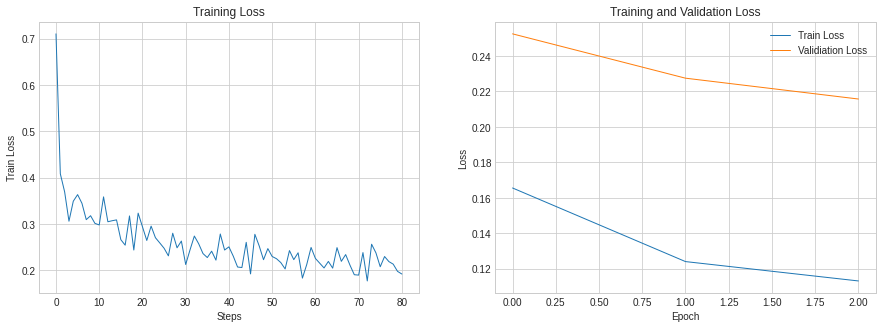

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

epovec = range(len(t_loss_in_batches))
plt.plot(epovec, t_loss_in_batches, linewidth=1)
# annotations:
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Train Loss")
# plt.show()

# plot_train_loss(t_loss_in_batches, plt)
plt.subplot(1, 2, 2)
# plt.figure(figsize=(5,5))
epovec = range(len(t_loss))
plt.plot(epovec, t_loss, epovec, v_loss, linewidth=1)
plt.legend(('Train Loss', 'Validiation Loss'))

# annotations:
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 7. Test

### 7.1 Test Function
- In test function, different from training process, we do not divide
the singe trajectory into different samples.
In contrast, we get the ground truth and predicted trajectories directly.
Then we use three matrics which called ADE, FDE and missRate to
evaluate the results.

In [ ]:
def test_func(model, trajectory, SEQ_LENGTH, PREDICTED_LENGTH):
    # get trajectories contrains x, y, (speed, acceleration, heading rate)
    traj_with_xyvar = []
    traj_with_xy = []
    for tra in trajectory:
        traj_with_xyvar.append(tra[2:7])
        traj_with_xy.append(tra[2:4])

    # scale the data
    # test data with x, y, speed, acceleration, heading rate
    scaler = MinMaxScaler(feature_range=(-1, 1))
    xyvar = scaler.fit_transform(traj_with_xyvar)

    # test data with x, y, speed, acceleration, heading rate
    scaler_new = MinMaxScaler(feature_range=(-1, 1))
    xy_new = scaler_new.fit_transform(traj_with_xy)

    # get the x, y, speed, acceleration, heading rate respectively, shape: [m, 1]
    x_s, y_s, v_s, a_s, r_s = xyvar[:, 0], xyvar[:,
                                                 1], xyvar[:, 2], xyvar[:, 3], xyvar[:, 4]

    # get the x, y ground truth of x, y
    # and speed, acceleration, heading rate as the test data to the model
    x, expected_x = [x_s[0:SEQ_LENGTH]
                     ], x_s[SEQ_LENGTH:SEQ_LENGTH + PREDICTED_LENGTH]
    y, expected_y = [y_s[0:SEQ_LENGTH]
                     ], y_s[SEQ_LENGTH:SEQ_LENGTH + PREDICTED_LENGTH]
    v = [v_s[0:SEQ_LENGTH]]
    a = [a_s[0:SEQ_LENGTH]]
    r = [r_s[0:SEQ_LENGTH]]

    original_x, original_y = x_s[:SEQ_LENGTH], y_s[:SEQ_LENGTH]  # [8, 1]

    # convert datat to tensor and change the shape, shape: [1, 8, 1]
    dataX, dataY = reshape_data_2(x), reshape_data_2(y)
    dataV = reshape_data_2(v)
    dataA = reshape_data_2(a)
    dataR = reshape_data_2(r)

    # return origin x, y and ground truth for plot
    # origin data
    original_x = reshape_data_1(original_x)
    original_y = reshape_data_1(original_y)  # [8 ,1]
    original_xy = torch.cat([original_x, original_y], dim=1)  # [8, 2]
    data_original = scaler_new.inverse_transform(original_xy)  # [8, 2]
    # ground truth
    expected_x = reshape_data_1(expected_x)
    expected_y = reshape_data_1(expected_y)  # [m, 10, 1]
    ground_truth_xy = torch.cat([expected_x, expected_y], dim=1)  # [10, 2]
    data_expected = scaler_new.inverse_transform(ground_truth_xy)  # [10, 2]

    # eval
    model.eval()

    with torch.no_grad():
        # cat trjectories data with x, y, speed, acceleration, heading rate to test
        cat_data = torch.cat(
            [dataX, dataY, dataV, dataA, dataR], dim=2)  # [m, 8, 5]
        cat_data = cat_data.to(device)
        # test model
        output_x, output_y = model(cat_data)  # [m, 10, 1]

        # concat output
        output = torch.cat([output_x, output_y],
                           dim=2).cpu().data  # [m, 10, 2]
        output = torch.reshape(output, [output.shape[1], output.shape[2]])

        # predicted data
        predicted_data = scaler_new.inverse_transform(output)  # [m, 10, 2]

    return predicted_data, data_expected, data_original

### 7.2 Metrics
- ADE, FDE and missRate

In [ ]:
p_one_mode = np.array([[1.]])


def Metrics(lstm, test_data, SEQ_LENGTH, PREDICTED_LENGTH):
    # initialization
    avg_ade = 0
    avg_fde = 0
    avg_missRate = 0
    length = len(test_data)
    plot_data = []

    # get predicted, origin and ground truth x, y
    for tra in tqdm(test_data):
        # clean nan
        tra = clean_nan(tra)

        # remove short trajectories
        if len(tra) < 20:
            length -= 1
            continue
        if tra[0][-1] == 0:
            continue

        # get predicted, origin and ground truth x, y from test function(model)
        predicted_data, data_expected, data_original = test_func(
            lstm, tra, SEQ_LENGTH, PREDICTED_LENGTH)

        # collect trajectories data
        plot_data.append([predicted_data, data_expected, data_original])

        # convert the data to the nuscenes ade, fde, missRate function format
        modes = data_expected.shape[0]
        x_one_mode, y_one_mode = traj2modes(
            predicted_data), traj2modes(data_expected)

        # compute ade, fde and missRate with nuscenes metrics
        ade = metrics.min_ade_k(x_one_mode, y_one_mode, p_one_mode)
        fde = metrics.min_fde_k(x_one_mode, y_one_mode, p_one_mode)
        missRate = metrics.miss_rate_top_k(
            x_one_mode, y_one_mode, p_one_mode, 2)

        # avg_ade, avg_fde and avg_missRate
        avg_ade += ade
        avg_fde += fde
        avg_missRate += missRate

    avg_ade = avg_ade / length
    avg_fde = avg_fde / length
    avg_missRate = 1 - avg_missRate / length
    print()
    print("avg_ade:", avg_ade[0][0])
    print("avg_fde:", avg_fde[0][0])
    print("avg_missRate:", avg_missRate[0][0])

    return plot_data, avg_ade, avg_fde, avg_missRate

In [ ]:
plot_data, avg_ade, avg_fde, avg_missRate = Metrics(
    cnn_lstm, test_data, SEQ_LENGTH, PREDICTED_LENGTH)

  0%|          | 0/3501 [00:00<?, ?it/s]


avg_ade: 1.152837239360219
avg_fde: 2.1436020780866762
avg_missRate: 0.7627215551743853


### 7.3 Trajectory Visulization
- In this section, we choose 12 predicted trajectories to make 
visualization. 

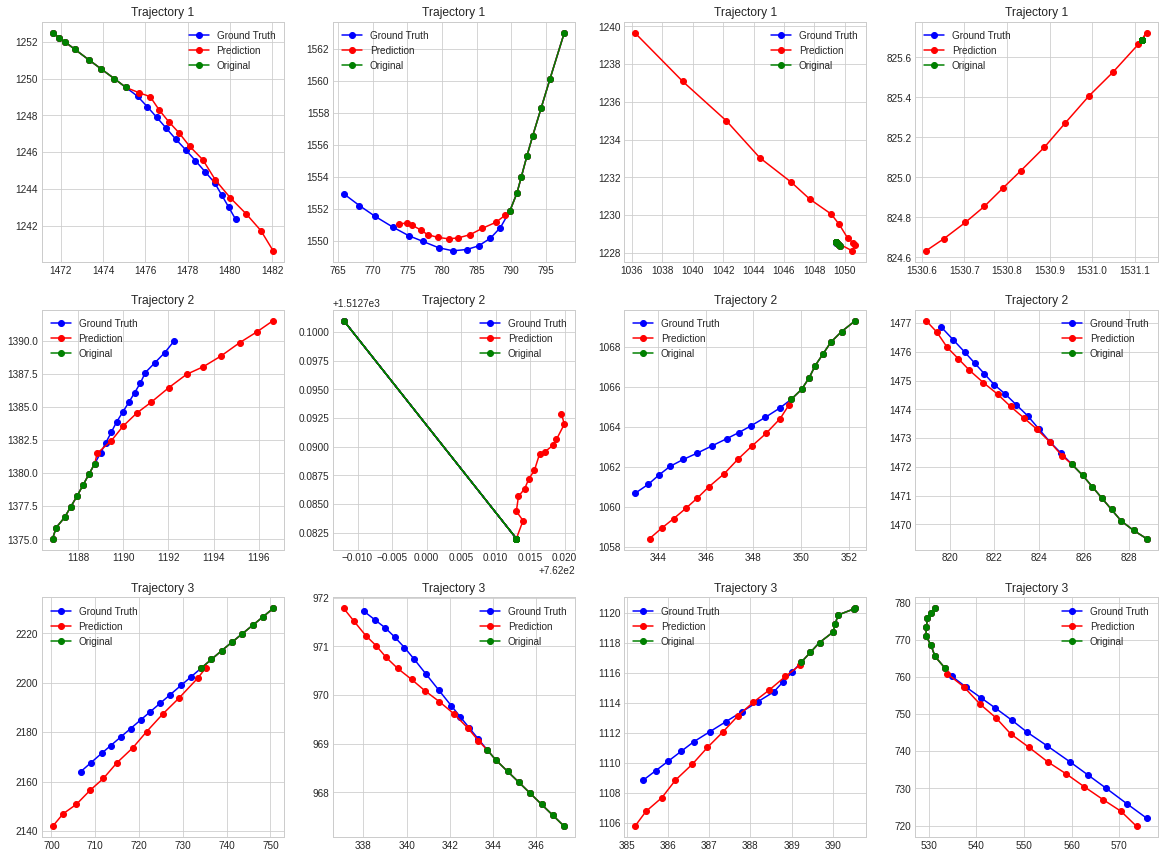

In [ ]:
num = 15
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

for i in range(3):
    for j in range(4):
        x_predicted = plot_data[i * 4 + j + num][0][:, 0]  # predicted x
        x_expected = plot_data[i * 4 + j + num][1][:, 0]  # expected x
        x_original = plot_data[i * 4 + j + num][2][:, 0]  # original x
        y_predicted = plot_data[i * 4 + j + num][0][:, 1]  # predicted x
        y_expected = plot_data[i * 4 + j + num][1][:, 1]  # expected x
        y_original = plot_data[i * 4 + j + num][2][:, 1]  # original x
        X_gt = np.append(x_original, x_expected)
        Y_gt = np.append(y_original, y_expected)

        X_predict = np.append(x_original, x_predicted)
        Y_predict = np.append(y_original, y_predicted)

        line_1, = ax[i, j].plot(
            X_gt, Y_gt, linestyle='solid', marker='o', color='blue')
        line_2, = ax[i, j].plot(X_predict, Y_predict,
                                linestyle='solid', marker='o', color='red')
        line_3, = ax[i, j].plot(x_original, y_original,
                                linestyle='solid', marker='o', color='green')
        ax[i, j].legend([line_1, line_2, line_3], [
                        'Ground Truth', 'Prediction', 'Original'])
        ax[i, j].set_title("Trajectory " + str(i + 1))

### 7.4 Model Comparison
In the final section, we compared the metrics from 7 different models.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  app.launch_new_instance()


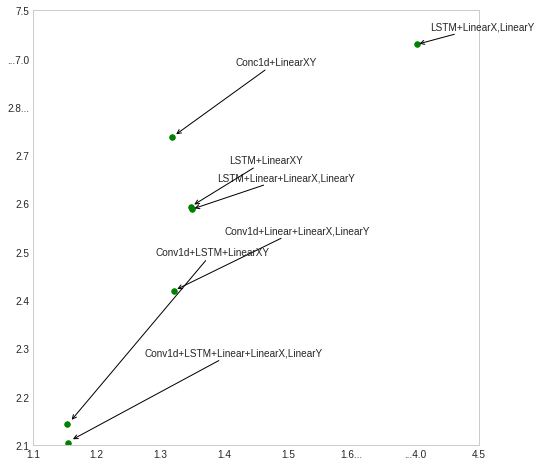

In [ ]:
avg_ades = np.array([4.026117876916457, 1.3494736074724063, 1.3484351713365064, 1.320634407368731, 1.3181920528809177,
                      1.155114251861771, avg_ade[0][0]])
avg_fdes = np.array(
    [7.337618028983116, 2.588020555647128, 2.5941970892462106, 2.418540712945231, 2.7372744572372147, 2.1056027991212427,
     avg_fde[0][0]])
plt.figure(figsize=(8, 8))

avg_ades[0] = 1.703
avg_fdes[0] = 2.93
plt.scatter(avg_ades, avg_fdes, s=30, c="g", alpha=1, label="Luck")

plt.grid()
annotations = ['LSTM+LinearX,LinearY', 'LSTM+Linear+LinearX,LinearY', 'LSTM+LinearXY', 'Conv1d+Linear+LinearX,LinearY', 'Conc1d+LinearXY',
               'Conv1d+LSTM+Linear+LinearX,LinearY', 'Conv1d+LSTM+LinearXY']

plt.axis([1.1, 1.7, 2.1, 3], scaled=True)

tick_locs_x = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
tick_lbls_x = [1.1, 1.2, 1.3, 1.4, 1.5, '1.6...', '...4.0', 4.5]
plt.xticks(tick_locs_x, tick_lbls_x)

tick_locs_y = [2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]
tick_lbls_y = [2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, '2.8...', '...7.0', 7.5]
plt.yticks(tick_locs_y, tick_lbls_y)

for i, (x, y) in enumerate(zip(avg_ades, avg_fdes)):
    if i == 6:
        plt.annotate(annotations[i], (x + 0.001 * i, y + 0.001 * i), (x + 0.02 * (i + 1), y + 0.05 * (i + 1)),
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
        continue
    plt.annotate(annotations[i], (x + 0.001 * i, y + 0.001 * i), (x + 0.020 * (i + 1), y + 0.030 * (i + 1)),
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.show()

|Model|LSTM+LinearX,LinearY|LSTM+Linear+LinearX,LinearY|LSTM+LinearXY|Conv1d+Linear+LinearX,LinearY|Conc1d+LinearXY|Conv1d+LSTM+Linear+LinearX,LinearY|Conv1d+LSTM+LinearXY|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|Average ADE|4.03|1.35|1.35|1.32|1.32|1.16|**1.15**|
|Average FDE|7.34|2.59|2.59|2.42|2.74|2.11|**2.14**|
|Miss Rate|66.61%|74.96%|75.12%|74.10%|74.39%|76.19%|**76.27%**|